In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# leemos las ubicaciones de los episodios
pahts = os.listdir("../data/processed/episodios/")

# inicializamos un dataframe con la estructura definida
episodios = pd.DataFrame(columns=['name_podcast', 'publiser', 'id_publiser', 'total_episodios',
       'description', 'duration', 'id_episodio', 'language', 'name_episodio',
       'release_date', 'type'])

# concatenamos los episodios
for path in pahts:
    df_aux = pd.read_csv("../data/processed/episodios/"+path)
    episodios = pd.concat([episodios, df_aux])
    

# corregimos un error en la fecha
episodios = episodios[episodios["release_date"]!="0201-04-28"] 

# transformamos el tipo fecha y ordenamos los capitulos
episodios["release_date"] = pd.to_datetime(episodios["release_date"])
episodios.sort_values("release_date", inplace=True)

# eliminamos duplicados, reiniciamos los indixes y filtramos los capitulos que no esten en espanol.
episodios = episodios.drop_duplicates()
episodios = episodios.reset_index().drop(columns="index")
episodios = episodios[episodios.language.str.startswith("es", na = False)]

## Analisis general

### Podcast diarios

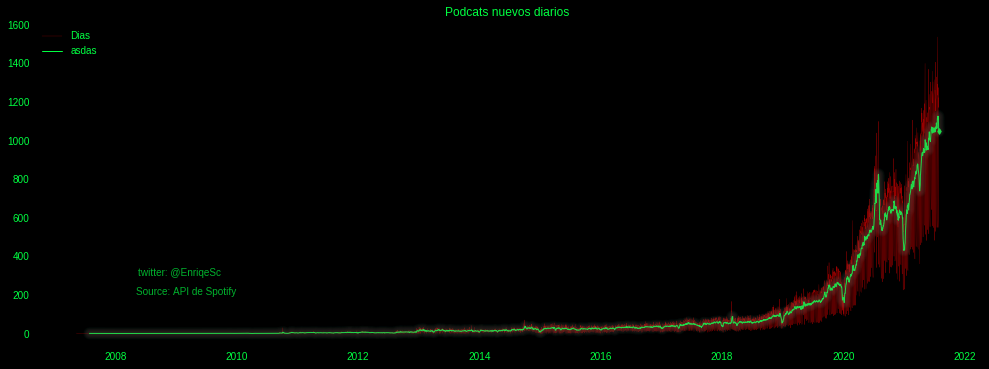

In [82]:
podcast_diarios = episodios[episodios.release_date<pd.to_datetime("2021-07-29")].groupby("release_date").publiser.count()
podcast_diarios.name="Podcast diarios"

podcast_mm = podcast_diarios.rolling(window=7).mean()
podcast_mm.name = "Media movil"

plt.style.use("seaborn-dark")
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#000000'  

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '#00ff41' 

fig, ax = plt.subplots(figsize=(17,6))
plt.plot(podcast_diarios, linewidth=0.3, alpha=0.6, c="red", label="Dias")
plt.plot(podcast_mm,linewidth=1, color="#00ff41", label="asdas")
plt.plot(pd.to_datetime("2021-07-28"), podcast_mm[-1], marker="d", color="#00ff41", markersize=4)

n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.03

for n in range(1, n_lines+1):

    plt.plot(podcast_mm,
            linewidth=2+(diff_linewidth*n),
            alpha=alpha_value)
    
plt.legend(loc="upper left")
plt.text(pd.to_datetime("2009-10-01"), 300,'twitter: @EnriqeSc', ha='right', alpha=0.7)
plt.text(pd.to_datetime("2010-01-01"), 200,'Source: API de Spotify', ha='right', alpha=0.7)
plt.title("Podcats nuevos diarios")
plt.show()

### Por país con variante español

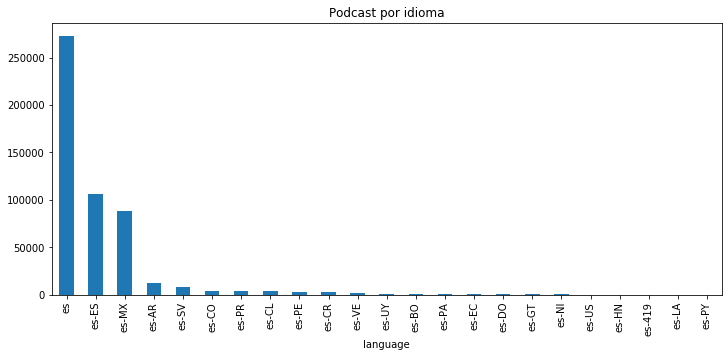

In [172]:
episodios.groupby("language").id_publiser.count().sort_values(ascending=False).plot(kind="bar", figsize=(12,5), rot=0)
plt.xticks(rotation=90)
plt.title("Podcast por idioma")
plt.show()

### Podcast nacidos

In [86]:
fechas_de_nacimiento = episodios.groupby("id_publiser").head(1)[["id_publiser", "total_episodios", "language",
                                                               "release_date"]]
fechas_de_nacimiento.rename(columns={"release_date":"bird_date"}, inplace=True)

fechas_de_sepelio = episodios.groupby("id_publiser").tail(1)[["id_publiser", "total_episodios", "language",
                                                               "release_date"]]


fecha_crecimiento = pd.merge(fechas_de_nacimiento, fechas_de_sepelio, on=["id_publiser", "total_episodios",
                                                                          "language"])

fecha_crecimiento["release_date"] = fecha_crecimiento["release_date"]+pd.Timedelta(weeks=7)
fecha_crecimiento["release_date"] = fecha_crecimiento["release_date"].apply(lambda x: pd.to_datetime("2021-07-29") if x>pd.to_datetime("2021-07-28") else x)

date_creados = pd.date_range(start=pd.to_datetime("2007-05-12"), end=pd.to_datetime("2021-07-28"), freq="D")

activos = []
nacidos = []
cerrados = []

for i in date_creados:
    activos.append(fecha_crecimiento[(fecha_crecimiento.bird_date<=i) & 
                  (i<=fecha_crecimiento.release_date)].shape[0])
    nacidos.append(fecha_crecimiento[fecha_crecimiento.bird_date==i].shape[0])
    cerrados.append(fecha_crecimiento[fecha_crecimiento.release_date<i].shape[0])
    
    
informacion_podcats = pd.DataFrame({"date":date_creados, "activos":activos, "nacidos":nacidos, "cerrados":cerrados})

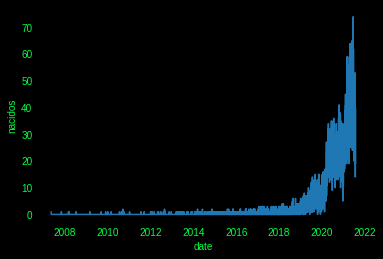

In [87]:
sns.lineplot(x="date", y="nacidos", data=informacion_podcats[informacion_podcats.date<pd.to_datetime("2021-07-29")])

In [94]:
informacion_podcats["nacidos_acumulados"] = informacion_podcats.nacidos.cumsum()

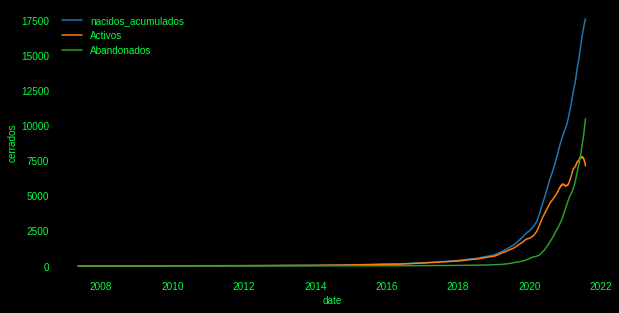

In [95]:
fig, axs = plt.subplots(figsize=(10,5))
sns.lineplot(x="date", y="nacidos_acumulados", data=informacion_podcats, label='nacidos_acumulados')
sns.lineplot(x="date", y="activos", data=informacion_podcats, label='Activos')
sns.lineplot(x="date", y="cerrados", data=informacion_podcats, label="Abandonados")
plt.legend()
plt.show()

## Comportamiento México

### Episodios diarios

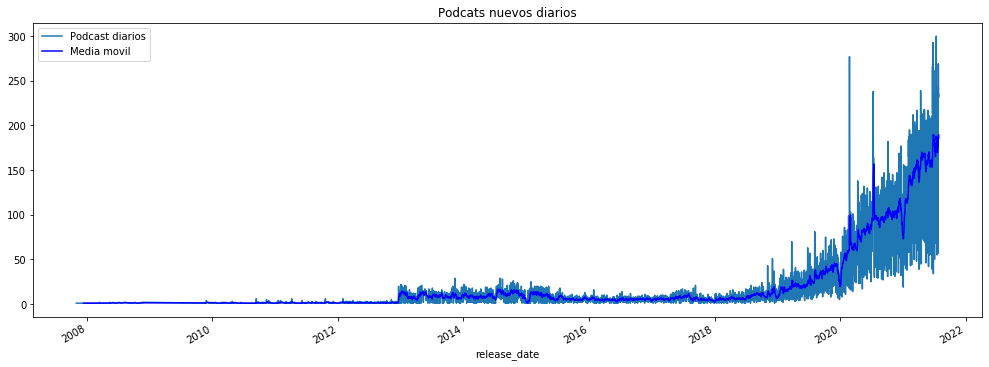

In [188]:
episodios_mexico = episodios[episodios.language=="es-MX"]
podcast_diarios = episodios_mexico[episodios_mexico.release_date<pd.to_datetime("2021-07-29")].groupby("release_date").publiser.count()
podcast_diarios.name="Podcast diarios"

podcast_mm = podcast_diarios.rolling(window=7).mean()
podcast_mm.name = "Media movil"

fig, ax = plt.subplots(figsize=(17,6))
podcast_diarios.plot()
podcast_mm.plot(c="blue")
plt.legend()
plt.title("Podcats nuevos diarios")
plt.show()

In [189]:
fechas_de_nacimiento = episodios_mexico.groupby("id_publiser").head(1)[["id_publiser", "total_episodios", "language",
                                                               "release_date"]]
fechas_de_nacimiento.rename(columns={"release_date":"bird_date"}, inplace=True)

fechas_de_sepelio = episodios_mexico.groupby("id_publiser").tail(1)[["id_publiser", "total_episodios", "language",
                                                               "release_date"]]


fecha_crecimiento = pd.merge(fechas_de_nacimiento, fechas_de_sepelio, on=["id_publiser", "total_episodios",
                                                                          "language"])

fecha_crecimiento["release_date"] = fecha_crecimiento["release_date"]+pd.Timedelta(weeks=7)
fecha_crecimiento["release_date"] = fecha_crecimiento["release_date"].apply(lambda x: pd.to_datetime("2021-07-29") if x>pd.to_datetime("2021-07-28") else x)

date_creados = pd.date_range(start=pd.to_datetime("2007-05-12"), end=pd.to_datetime("2021-07-29"), freq="D")

activos = []
nacidos = []
cerrados = []

for i in date_creados:
    activos.append(fecha_crecimiento[(fecha_crecimiento.bird_date<=i) & 
                  (i<=fecha_crecimiento.release_date)].shape[0])
    nacidos.append(fecha_crecimiento[fecha_crecimiento.bird_date==i].shape[0])
    cerrados.append(fecha_crecimiento[fecha_crecimiento.release_date<i].shape[0])
    
    
informacion_podcats = pd.DataFrame({"date":date_creados, "activos":activos, "nacidos":nacidos, "cerrados":cerrados})

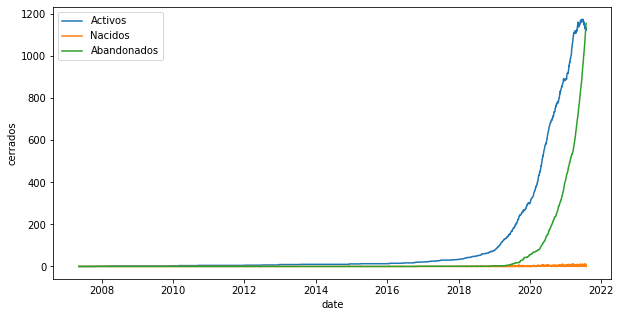

In [190]:
fig, axs = plt.subplots(figsize=(10,5))
sns.lineplot(x="date", y="activos", data=informacion_podcats, label='Activos')
sns.lineplot(x="date", y="nacidos", data=informacion_podcats, label="Nacidos")
sns.lineplot(x="date", y="cerrados", data=informacion_podcats, label="Abandonados")
plt.legend()
plt.show()

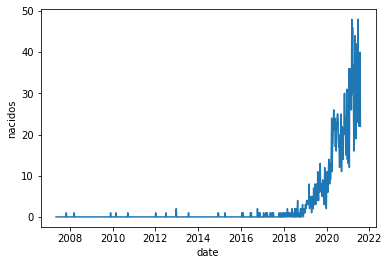

In [205]:
sns.lineplot(x="date", y="nacidos", data=informacion_podcats.resample("W").nacidos.sum().reset_index())